## Pymaceuticals Inc.

### Drugs vs tumor

In [80]:
# Dependencies
import pandas as pd
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set up the path to files with data
mouse_data_file = 'Resources/Mouse_metadata.csv'
study_result_data_file = 'Resources/Study_results.csv'

In [3]:
# Read mouse_metadata.csv file to DataFrame
mouse_original_df = pd.read_csv(mouse_data_file)
mouse_original_df.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [4]:
# Read study_result.csv to DataFrame
study_res_original_df = pd.read_csv(study_result_data_file)
study_res_original_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [5]:
# Merge both df together. Inner join because we need anly mouse that included in study_result file
summary_df = study_res_original_df.merge(mouse_original_df, on='Mouse ID', how='inner')
summary_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [6]:
# Find duplicated mouses 
duplicated_row_df = summary_df[summary_df.duplicated(['Mouse ID', 'Timepoint'])]
duplicated_row_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
861,g989,0,45.000000,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [7]:
# Get mouse id from duplicated df
mouse_id = duplicated_row_df['Mouse ID'].unique()
mouse_id = mouse_id[0]

# delete all rows with given mouse id
summary_df.drop(summary_df[summary_df['Mouse ID'] == mouse_id].index, inplace=True)
len(summary_df['Mouse ID'].unique())

248

#### Summary Statistics

Generate a summary statistics table consisting of the mean, median, variance, standard deviation, and SEM of the tumor volume for each drug regimen.

In [28]:
# groupby by drug regime
regime = summary_df.groupby('Drug Regimen')

# generate mean 
mean_tumor_volume = regime['Tumor Volume (mm3)'].mean()

# generate median
median_tumor_volume = regime['Tumor Volume (mm3)'].median()

drugs = summary_df['Drug Regimen'].unique()
drugs

# variable to store variance, standart deviation and sem for each drug
variance = []
st_dv = []
std_err = []

for drug in drugs:
    certain_drug = summary_df[summary_df['Drug Regimen'] == drug]
    #tumor_volume = certain_drug[]
    variance.append(scs.tvar(certain_drug['Tumor Volume (mm3)']))
    st_dv.append(scs.tstd(certain_drug['Tumor Volume (mm3)']))
    n_obs.append(len(certain_drug))
    std_err.append(scs.sem(certain_drug['Tumor Volume (mm3)']))

    
# Create a summary df
base_statistics_df = pd.DataFrame({"Mean Tumor Volume": mean_tumor_volume
                                  , "Median Tumor Volume": median_tumor_volume
                                  , "Tumor Volume Variance": variance
                                  , 'Tumor Volum Std. Dev.': st_dv
                                  , "Tumor Volum Std. Err": std_err})
base_statistics_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volum Std. Dev.,Tumor Volum Std. Err
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,68.553577,8.279709,0.603860
Infubinol,52.884795,51.820584,66.173479,8.134708,0.596466
Ketapril,55.235638,53.698743,43.128684,6.567243,0.492236
Naftisol,54.331565,52.509285,59.450562,7.710419,0.573111
Placebo,54.033581,52.288934,23.486704,4.846308,0.320955
Propriva,52.320930,50.446266,48.533355,6.966589,0.516398
Ramicane,40.216745,40.673236,43.852013,6.622085,0.544332
Stelasyn,54.233149,52.431737,61.168083,7.821003,0.581331


In [64]:
summary_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22


[Text(0, 0.5, 'Number of Unique Mice Tested'),
 Text(0.5, 0, 'Drug Regimen'),
 Text(0.5, 1.0, 'Mice vs Drug regimen')]

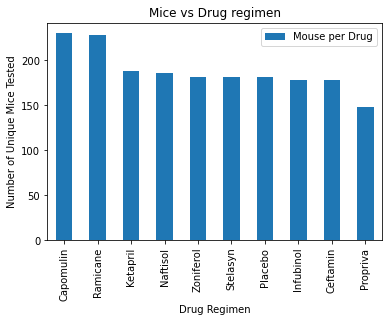

In [107]:
# Bar chart via pandas.plot
mouse_per_drugs = []

for drug in drugs:
    mouse_per_drugs.append(summary_df[summary_df['Drug Regimen'] == drug]['Mouse ID'].count())

    
mouse_per_drugs

mouse_vs_drugs_df = pd.DataFrame({'Drugs': drugs, 'Mouse per Drug': mouse_per_drugs}, index=drugs)
mouse_vs_drugs_df= mouse_vs_drugs_df.sort_values(by='Mouse per Drug', ascending=False)
bar_plot = mouse_vs_drugs_df.plot.bar()
bar_plot.set(xlabel='Drug Regimen', ylabel='Number of Unique Mice Tested', title='Mice vs Drug regimen')

Text(0.5, 1.0, 'Mice vs Drug regimen')

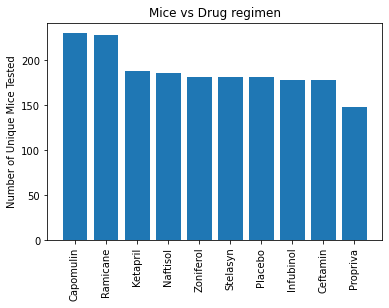

In [105]:
# Matplotlib Bar Chart 

#plt.bar(drugs, mouse_per_drugs)
plt.bar(mouse_vs_drugs_df['Drugs'], mouse_vs_drugs_df['Mouse per Drug'])
plt.xticks(rotation=90, horizontalalignment="center")
plt.xlabel='Drug Regimen'
plt.ylabel('Number of Unique Mice Tested')
plt.title('Mice vs Drug regimen')